# 1. Regression Code

### The Code Below Performs a Regression from X to Y

Copyright (c) 2010-2013  Jonas Peters  [peters@stat.math.ethz.ch]

```
train_*** <- function(X, y, pars)  (e.g. train_linear or train_gp)
```
```
INPUT:
  X         nxp matrix of training inputs (n data points, p dimensions)
  Y         vector of N training outputs (n data points)
  pars      list containing parameters of the regression method

OUTPUT:
  result    list with the result of the regression
  $model        list of learned model (e.g., weight vector)
  $Yfit         fitted outputs for training inputs according to the learned model
  $residuals    noise values (e.g., residuals in the additive noise case) 
```

###### Linear Regression

In [1]:
train_linear <- function(X,y,pars = list()) {
    mod <- lm(y ~ X)
    result <- list()
    result$Yfit = as.matrix(mod$fitted.values)
    result$residuals = as.matrix(mod$residuals)
    result$model = mod
    #for coefficients see list(mod$coef)
    return(result)
}

##### GP Regression

In [2]:
gp_regression <- function(X,y, pars=list()) {
    options=gpOptions("ftc")
    options$kern$comp=list("rbf","white")
    #options$learnScales=TRUE
    model<-gpCreate(dim(X)[2],1,X,y,options)
    y2<-gpOut(model,X)
    model$Yfit<-y2
    model$residuals<-y-y2
    return(model)
}

train_gp <- function(X,y,pars = list()) {
    library(gptk)
    mod <- gp_regression(as.matrix(X),as.matrix(y))
    result <- list()
    result$Yfit = mod$Yfit
    result$residuals = mod$residuals
    result$model = mod
    return(result)
}

##### Gam Regression

In [3]:
library(mgcv)
train_gam <- function(X,y,pars = list(numBasisFcts = 10)) {
    if(!("numBasisFcts" %in% names(pars) ))  { 
        pars$numBasisFcts = 10
    }
    
    p <- dim(as.matrix(X))
    if(p[1]/p[2] < 3*pars$numBasisFcts) {
        pars$numBasisFcts <- ceiling(p[1]/(3*p[2]))
        cat("changed number of basis functions to    ", pars$numBasisFcts, "    in order to have enough samples per basis function\n")
    }
    dat <- data.frame(as.matrix(y),as.matrix(X))
    coln <- rep("null",p[2]+1)
    for(i in 1:(p[2]+1)) {
        coln[i] <- paste("var",i,sep="")
    }
    colnames(dat) <- coln
    labs<-"var1 ~ "
    if(p[2] > 1) {
        for(i in 2:p[2]) {
            labs<-paste(labs,"s(var",i,",k = ",pars$numBasisFcts,") + ",sep="")
        }
    }
    labs<-paste(labs,"s(var",p[2]+1,",k = ",pars$numBasisFcts,")",sep="")
    mod_gam <- FALSE
    try(mod_gam <- gam(formula=formula(labs), data=dat),silent = TRUE)
    if(typeof(mod_gam) == "logical") {
        cat("There was some error with gam. The smoothing parameter is set to zero.\n")
        labs<-"var1 ~ "
        if(p[2] > 1) {
            for(i in 2:p[2]) {
                labs<-paste(labs,"s(var",i,",k = ",pars$numBasisFcts,",sp=0) + ",sep="")
            }
        }
        labs<-paste(labs,"s(var",p[2]+1,",k = ",pars$numBasisFcts,",sp=0)",sep="")
        mod_gam <- gam(formula=formula(labs), data=dat)
    }
    result <- list()
    result$Yfit <- as.matrix(mod_gam$fitted.values)
    result$residuals <- as.matrix(mod_gam$residuals)
    result$model <- mod_gam 
    result$df <- mod_gam$df.residual     
    result$edf <- mod_gam$edf     
    result$edf1 <- mod_gam$edf1     
    
    # for degree of freedom see mod_gam$df.residual
    # for aic see mod_gam$aic
    return(result)
}

Loading required package: nlme
This is mgcv 1.8-24. For overview type 'help("mgcv-package")'.


##### GAM Boost

In [4]:
library(mboost)
train_GAMboost <- function(X,y,pars = list()) #
{
    ## begin old version
    # EXPLANATION: surprisingly, it turned out that this cannot be applied to large p (private discussion with T. Hothorn in Sep 2013)
    # yy <- y
    # dat <- data.frame(cbind(yy,X))
    # gb <- gamboost(yy ~ .,data=dat, baselearner = "bbs")
    ## end old version
    
    ## begin new version
    dat <- as.data.frame(X)
    bl <- lapply(dat, bbs)
    gb <- mboost_fit(bl, y)
    ## end new version
    
    result <- list()
    result$Yfit <- gb$fitted()
    result$residuals <- gb$resid()
    result$model <- gb
    return(result)
}

Loading required package: parallel
Loading required package: stabs
This is mboost 2.9-1. See ‘package?mboost’ and ‘news(package  = "mboost")’
for a complete list of changes.



##### Pen GAM

In [5]:
train_penGAM <- function(X,y,pars = list(kCV = 3))
{
    # Meier, L., van de Geer, S. and Bühlmann, P. (2009). High-Dimensional Additive Modeling. Annals of Statistics 37, 3779-3821
    # code available from Lukas Meier [meier@stat.math.ethz.ch]
    # !! It is not so easy to find good values for cross-validation !!
    war <- library(penGAM, logical.return=TRUE)
    if(!war)
    {
        error("penGAM regression cannot be used because the package (based on Meier, L. et al. High-Dimensional Additive Modeling. 2009) cannot be loaded. Code is available from Lukas Meier [meier@stat.math.ethz.ch]")
    }
    if(is.matrix(X))
    {
        dimX <- dim(X)[1]
    } else if(is.vector(X))
    {
        dimX <- length(X)
        X <- as.matrix(X)
    }
    
    # Cross-Validation
    
    allSets <- getSetsForKFoldCV(dimX, pars$kCV)
    trainSets <- allSets$trainSets
    testSets <- allSets$testSets 
    
    lambda.pen <- 0.955^seq(1,120,by=30)
    #lambda.pen  <- 0.9^(1:20) ## 0.955^(1:110) 0.955^(1:110) ## Special!!!
    #lambda.pen  <- c(0.5,0.2,0.1) ## 0.955^(1:110) 0.955^(1:110) ## Special!!!
    #lambda.pen  <- 0.95 ## 0.955^(1:110) 0.955^(1:110) ## Special!!!
    #lambda.pen = c(1, 0.9, 0.8, 0.5, 0.3, 0.1),
    
    lambda.curv <- c(2^(4:(-4)), 0)
    #lambda.curv <- c(2^(6:(-6)), 0)
    #lambda.curv = c(6, 4, 2, 1), 
    
    SS <- matrix(0,length(lambda.pen), length(lambda.curv))
    for(i in 1:pars$kCV)
    {
        kkk <- round(sqrt(dimX))
        fit.GAM <- penGAM(as.matrix(X[trainSets[[i]],]), as.matrix(y[trainSets[[i]]]), 
                          lambda.pen,
                          lambda.curv,
                          knots = kkk, 
                          #########################
                          # is this a good idea??????
                          #########################
                          model = LinReg(), control = grpl.control(trace = 0))
        pred <- predict(fit.GAM, newdata = as.matrix(X[testSets[[i]],]))
        for(pp in 1:length(lambda.pen))
        {
            for(cc in 1:length(lambda.curv))
            {
                SS[pp,cc] <- SS[pp,cc] + sum((pred[pp,cc,] - y[testSets[[i]]])^2)
            }
        }
    }
    
    #choose best lambdas
    opt <- arrayInd(which.min(SS),dim(SS))
    lambda.pen.opt <- lambda.pen[opt[1]]
    lambda.curv.opt <- lambda.curv[opt[2]]
    cat("Optimal value for lambda.pen: ", lambda.pen.opt, "\n")
    cat("Optimal value for lambda.curv: ", lambda.curv.opt, "\n")
    
    
    # fit a gam model    
    fit.GAM <- penGAM(as.matrix(X), as.matrix(y), 
                      lambda.pen.opt,
                      lambda.curv.opt,
                      knots = round(sqrt(dim(X)[1])),
                      model = LinReg(), control = grpl.control(trace = 0))
    
    result <- list()
    result$Yfit <- predict(fit.GAM,X)
    result$residuals <- y - result$Yfit
    result$model <- fit.GAM
    return(result)
}

##### Lasso

In [6]:
war <- library(glmnet, logical.return=TRUE)
if(!war)
{
    cat("The package glmnet is not installed. This only means that lasso regression cannot be performed. However, this has no effect of the standard GAM version.\n")
}
train_lasso <- function(X,y,pars = list())
{
    cvres <- cv.glmnet(X,y)
    mod <- glmnet(X,y,lambda = cvres$lambda.1se)
    result <- list()
    result$Yfit <- predict(mod,X)
    result$residuals <- y - result$Yfit
    result$model <- mod
    return(result)
}

Warning message in library(glmnet, logical.return = TRUE):
“there is no package called ‘glmnet’”

The package glmnet is not installed. This only means that lasso regression cannot be performed. However, this has no effect of the standard GAM version.


##### Logistic Regression

In [8]:
library(glm)
logistic_regression <- function()

ERROR: Error in parse(text = x, srcfile = src): <text>:3:0: unexpected end of input
1: library(glm)
2: logistic_regression <- function()
  ^


##### Train Model

In [9]:
train_model <- function(f,X,y,pars = list())
{
    result <- f(X,y,pars)
}

# 2. Independence Test

##### The Code Below Performs an Independence Test using the Hilbert-Schmidt Independence Critertion
Copyright (c) 2010 - 2013  Jonas Peters  [peters@stat.math.ethz.ch]

outputs the test statistic (N*HSIC) and the critical value (according to alpha). If the test statistic is larger than the critical value, H_0 (X and Y are independent) is rejected.

In [209]:
library(kernlab)
indtestHsic <- function(x,y,alpha=0.05, pars = list(method = "IncChol")) {    
    if(is.matrix(x)==FALSE){
        x<-as.matrix(x)}
    if(is.matrix(y)==FALSE){
        y<-as.matrix(y)}
    len <- dim(x)[1]
    
    # compute distance matrices
    xnorm<-as.matrix(dist(x,method="euclidean",diag=TRUE,upper=TRUE))
    xnorm<-xnorm^2
    ynorm<-as.matrix(dist(y,method="euclidean",diag=TRUE,upper=TRUE))
    ynorm<-ynorm^2
    
    # choose median heuristic for bandwidth
    if(len>1000) {
        sam <- sample(1:len,1000)
        xhilf<-xnorm[sam,sam]
        yhilf<-ynorm[sam,sam]
    } else {
        xhilf<-xnorm
        yhilf<-ynorm
    }
    
    sigmax<-sqrt(0.5*median(xhilf[lower.tri(xhilf,diag=FALSE)]))
    sigmay<-sqrt(0.5*median(yhilf[lower.tri(yhilf,diag=FALSE)]))
    
    
    if(pars$method == "Exact" || pars$method == "ExactFastTrace") {
        ###
        # Compute GramMat
        ###
        ptm <- proc.time()
        KX <- exp(-xnorm/(2*sigmax^2))
        KY <- exp(-ynorm/(2*sigmay^2))
        timeGramMat <- (proc.time() - ptm)[1]
        
        ###
        # Compute HSIC
        ###
        if(pars$method == "Exact") {
            ptm <- proc.time()
            H<-diag(1,len)-1/len*matrix(1,len,len)
            HSIC <- 1/(len^2)*sum(diag(KX%*%H%*%KY%*%H))
            timeHSIC <- (proc.time() - ptm)[1]
        }
        if(pars$method == "ExactFastTrace") {
            ptm <- proc.time()
            H<-diag(1,len)-1/len*matrix(1,len,len)
            HSIC <- 1/(len^2) * sum((KX - 1/len*(KX%*%rep(1,len))%*%t(rep(1,len)))*t(KY - 1/len*(KY%*%rep(1,len))%*%t(rep(1,len))))
            timeHSIC <- (proc.time() - ptm)[1]
        }
        
        ###
        # Compute Gamma Approximation
        ###
        ptm <- proc.time()
        mux <- (sum(KX)-len)/(len*(len-1))
        muy <- (sum(KY)-len)/(len*(len-1))
        
        mean_h0 <- 1/len*(1+mux*muy-mux-muy)
        var_h0 <- (2*(len-4)*(len-5))/(len*(len-1)*(len-2)*(len-3)) * 1/((len-1)^2)*sum((KX - 1/len*(KX%*%rep(1,len))%*%t(rep(1,len)))*t(KX - 1/len*(KX%*%rep(1,len))%*%t(rep(1,len)))) * 1/((len-1)^2)*sum((KY - 1/len*(KY%*%rep(1,len))%*%t(rep(1,len)))*t(KY - 1/len*(KY%*%rep(1,len))%*%t(rep(1,len))))
        timeGamma <- (proc.time() - ptm)[1]
        
    }
    
    if(pars$method == "IncChol" || pars$method == "IncCholFastTrace") {
        ###
        # Compute GramMat
        ###
        ## incomplete cholesky decomposition
        ptm <- proc.time()
        LX <- inchol(x, kernel="rbfdot", kpar=list(sigma=1/(2*sigmax^2)), tol = 0.0001, maxiter = 300)
        LX <- matrix(LX,nrow=dim(LX)[1], ncol=dim(LX)[2])
        LY <- inchol(y, kernel="rbfdot", kpar=list(sigma=1/(2*sigmay^2)), tol = 0.0001, maxiter = 300)
        LY <- matrix(LY,nrow=dim(LY)[1], ncol=dim(LY)[2])
        LXc <- LX-1/len*(as.matrix(rep(1,len))%*%colSums(LX))
        LYc <- LY-1/len*(as.matrix(rep(1,len))%*%colSums(LY))
        timeGramMat <- (proc.time() - ptm)[1]
        
        ###
        # Compute HSIC
        ###
        if(pars$method == "IncChol") {
            ptm <- proc.time()
            HSIC <- 1/(len^2)*sum(diag((t(LX)%*%LYc)%*%(t(LY)%*%LXc)))
            timeHSIC <- (proc.time() - ptm)[1]
        }
        if(pars$method == "IncCholFastTrace") {
            ptm <- proc.time()
            HSIC <- 1/(len^2)*sum( (t(LX)%*%LYc) * t((t(LY)%*%LXc)))
            timeHSIC <- (proc.time() - ptm)[1]
        }
        
        ###
        # Compute Gamma Approximation
        ###
        ptm <- proc.time()
        mux <- (crossprod(colSums(LX))-len)/(len*(len-1))
        muy <- (crossprod(colSums(LY))-len)/(len*(len-1))
        
        mean_h0 <- 1/len*(1+mux*muy-mux-muy)
        var_h0 <- (2*(len-4)*(len-5))/(len*(len-1)*(len-2)*(len-3))*1/((len-1)^2)*sum(diag((t(LX)%*%LXc)%*%(t(LX)%*%LXc)))*1/((len-1)^2)*sum(diag((t(LY)%*%LYc)%*%(t(LY)%*%LYc)))
        timeGamma <- (proc.time() - ptm)[1]
    }        
    
    a <- (mean_h0^2)/var_h0
    b <- len*var_h0/mean_h0
    critical_value <- qgamma(1-alpha,shape=a,scale=b)
    p_value <- pgamma(len*HSIC,shape=a,scale=b, lower.tail=FALSE)
    resu <- list(statistic = len*HSIC, crit.value = critical_value, p.value = p_value, time = c(timeGramMat,timeHSIC,timeGamma))
    return(resu)
}


# 3. Additive Noise Model Code


In [823]:
test <- function(x, y, reg_model = train_linear, ind_test = indtestHsic, cut_off = 10, verbose = FALSE) {
    xToY <- train_GAMboost(x, y)
    yToX <- train_GAMboost(y, x)
    xToY.P <- ind_test(xToY$residuals, x)$p.value
    yToX.P <- ind_test(yToX$residuals, y)$p.value
    if (xToY.P > 10 * yToX.P) {
        result <- "X"
    } else if (xToY.P * 10 < yToX.P) {
        result <- "Y"
    } else {
        result <- "NA"
    }

    if (verbose) {
        message("P value for forward is ", xToY.P, ", P value for backword is ", yToX.P, " result is ", ifelse(is.na(result), "Inconclusive", result))
    }
        
    c(result, xToY.P, yToX.P)
}

# 4. Function to Test a Pair

In [12]:
process_file = function(filepath) {
    read.delim(filepath, header = FALSE, sep="", stringsAsFactors = FALSE)    
}

In [194]:
test_pair <- function(data) {
    result <- data.frame(FileName = character(),
                         TestParameter = character(),
                         RegressionModel = character(),
                         Collection = factor(),
                         ForwardPValue = double(),
                         BackwardPValue = double(),
                         Result = factor())

    message("Start testing file: ", file_path)
    message("/n")
    
    result <- test(
        data[["V1"]],
        data[["V2"]]
    )

    result
}


# 5. Now, test all of the pairs

In [587]:
results <- matrix(, nrow = 108, ncol = 3)
data_size <- vector(, length=108)
forward_models <- vector("list", length=108)
backward_models <- vector("list", length=108)

##### Pair 1

In [588]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0001.txt"
data <- process_file(file_path)
results_1 = test_pair(data)
print(results_1)

results[1, 1] = results_1[1]
results[1, 2] = as.numeric(results_1[2])
results[1, 3] = as.numeric(results_1[3])
data_size[1] <- nrow(data)

forward_models[[1]] <- glm(V2 ~ V1, data = data)
backward_models[[1]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0001.txt
/n


[1] "X"                    "6.37634844718238e-17" "2.73490976614775e-25"


##### Pair 2

In [589]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0002.txt"
data <- process_file(file_path)
results_2 = test_pair(data)
print(results_2)

results[2, 1] = results_2[1]
results[2, 2] = as.numeric(results_2[2])
results[2, 3] = as.numeric(results_2[3])
data_size[2] <- nrow(data)

forward_models[[2]] <- glm(V2 ~ V1, data = data)
backward_models[[2]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0002.txt
/n


[1] "NA"                   "8.97362197664129e-17" "2.39595626120772e-17"


##### Pair 3

In [590]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0003.txt"
data <- process_file(file_path)
results_3 = test_pair(data)
print(results_3)

results[3, 1] = results_3[1]
results[3, 2] = as.numeric(results_3[2])
results[3, 3] = as.numeric(results_3[3])
data_size[3] <- nrow(data)

forward_models[[3]] <- glm(V2 ~ V1, data = data)
backward_models[[3]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0003.txt
/n


[1] "X"                    "9.53978927992768e-08" "2.04386366515222e-19"


##### Pair 4

In [591]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0004.txt"
data <- process_file(file_path)
results_4 = test_pair(data)
print(results_4)

results[4, 1] = results_4[1]
results[4, 2] = as.numeric(results_4[2])
results[4, 3] = as.numeric(results_4[3])
data_size[4] <- nrow(data)

forward_models[[4]] <- glm(V2 ~ V1, data = data)
backward_models[[4]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0004.txt
/n


[1] "X"                    "0.0182466355584996"   "3.77426466862528e-06"


##### Pair 5

In [592]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0005.txt"
data <- process_file(file_path)
results_5 = test_pair(data)
print(results_5)

results[5, 1] = results_5[1]
results[5, 2] = as.numeric(results_5[2])
results[5, 3] = as.numeric(results_5[3])
data_size[5] <- nrow(data)

forward_models[[5]] <- glm(V2 ~ V1, data = data)
backward_models[[5]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0005.txt
/n


[1] "Y"                    "0"                    "8.18102866085081e-59"


##### Pair 6

In [593]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0006.txt"
data <- process_file(file_path)
results_6 = test_pair(data)
print(results_6)

results[6, 1] = results_6[1]
results[6, 2] = as.numeric(results_6[2])
results[6, 3] = as.numeric(results_6[3])
data_size[6] <- nrow(data)

forward_models[[6]] <- glm(V2 ~ V1, data = data)
backward_models[[6]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0006.txt
/n


[1] "Y"                    "0"                    "1.4654237225657e-125"


##### Pair 7

In [821]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0007.txt"
data <- process_file(file_path)
results_7 = test_pair(data)
print(results_7)

results[7, 1] = results_7[1]
results[7, 2] = as.numeric(results_7[2])
results[7, 3] = as.numeric(results_7[3])
data_size[7] <- nrow(data)

forward_models[[7]] <- glm(V2 ~ V1, data = data)
backward_models[[7]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0007.txt
/n


[1] "Y"                    "0"                    "1.52199307724905e-78"


##### Pair 8

In [788]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0008.txt"
data <- process_file(file_path)
results_8 = test_pair(data)
print(results_8)

results[8, 1] = results_8[1]
results[8, 2] = as.numeric(results_8[2])
results[8, 3] = as.numeric(results_8[3])
data_size[8] <- nrow(data)

forward_models[[8]] <- glm(V2 ~ V1, data = data)
backward_models[[8]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0008.txt
/n


[1] "Y"                     "7.80129654783328e-321" "2.47721949451832e-44" 


##### Pair 9

In [595]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0009.txt"
data <- process_file(file_path)
results_9 = test_pair(data)
print(results_9)

results[9, 1] = results_9[1]
results[9, 2] = as.numeric(results_9[2])
results[9, 3] = as.numeric(results_9[3])
data_size[9] <- nrow(data)

forward_models[[9]] <- glm(V2 ~ V1, data = data)
backward_models[[9]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0009.txt
/n


[1] "Y"                     "0"                     "1.15766299658088e-105"


##### Pair 10

In [596]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0010.txt"
data <- process_file(file_path)
results_10 = test_pair(data)
print(results_10)

results[10, 1] = results_10[1]
results[10, 2] = as.numeric(results_10[2])
results[10, 3] = as.numeric(results_10[3])
data_size[10] <- nrow(data)

forward_models[[10]] <- glm(V2 ~ V1, data = data)
backward_models[[10]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0010.txt
/n


[1] "Y"                    "0"                    "9.70380230225695e-97"


##### Pair 11

In [597]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0011.txt"
data <- process_file(file_path)
results_11 = test_pair(data)
print(results_11)

results[11, 1] = results_11[1]
results[11, 2] = as.numeric(results_11[2])
results[11, 3] = as.numeric(results_11[3])
data_size[11] <- nrow(data)

forward_models[[11]] <- glm(V2 ~ V1, data = data)
backward_models[[11]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0011.txt
/n


[1] "Y"                     "0"                     "3.00115699446088e-120"


##### Pair 12

In [598]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0012.txt"
data <- process_file(file_path)
results_12 = test_pair(data)
print(results_12)

results[12, 1] = results_12[1]
results[12, 2] = as.numeric(results_12[2])
results[12, 3] = as.numeric(results_12[3])
data_size[12] <- nrow(data)

forward_models[[12]] <- glm(V2 ~ V1, data = data)
backward_models[[12]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0012.txt
/n


[1] "Y"                     "1.64175623579961e-289" "9.95567901908085e-188"


##### Pair 13

In [599]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0013.txt"
data <- process_file(file_path)
results_13 = test_pair(data)
print(results_13)

results[13, 1] = results_13[1]
results[13, 2] = as.numeric(results_13[2])
results[13, 3] = as.numeric(results_13[3])
data_size[13] <- nrow(data)

forward_models[[13]] <- glm(V2 ~ V1, data = data)
backward_models[[13]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0013.txt
/n


[1] "X"                    "1.38622298742076e-23" "4.3499765635473e-55" 


##### Pair 14

In [600]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0014.txt"
data <- process_file(file_path)
results_14 = test_pair(data)
print(results_14)

results[14, 1] = results_14[1]
results[14, 2] = as.numeric(results_14[2])
results[14, 3] = as.numeric(results_14[3])
data_size[14] <- nrow(data)

forward_models[[14]] <- glm(V2 ~ V1, data = data)
backward_models[[14]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0014.txt
/n


[1] "X"                    "3.06317465573772e-31" "1.35991516341853e-47"


##### Pair 15

In [601]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0015.txt"
data <- process_file(file_path)
results_15 = test_pair(data)
print(results_15)

results[15, 1] = results_15[1]
results[15, 2] = as.numeric(results_15[2])
results[15, 3] = as.numeric(results_15[3])
data_size[15] <- nrow(data)

forward_models[[15]] <- glm(V2 ~ V1, data = data)
backward_models[[15]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0015.txt
/n


[1] "X"                    "1.96603213812734e-22" "3.86183978578115e-32"


##### Pair 16


In [602]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0016.txt"
data <- process_file(file_path)
results_16 = test_pair(data)
print(results_16)

results[16, 1] = results_16[1]
results[16, 2] = as.numeric(results_16[2])
results[16, 3] = as.numeric(results_16[3])
data_size[16] <- nrow(data)

forward_models[[16]] <- glm(V2 ~ V1, data = data)
backward_models[[16]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0016.txt
/n


[1] "X"                    "3.13395707433834e-05" "1.81505912952658e-37"


##### Pair 17

In [603]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0017.txt"
data <- process_file(file_path)

# Change the data type from int to numeric
for (row in 1:nrow(data)) {
    data[row, "V1"] <- as.numeric(data[row, "V1"])
    data[row, "V2"] <- as.numeric(data[row, "V2"])
}

results_17 = test_pair(data)
print(results_17)

results[17, 1] = results_17[1]
results[17, 2] = as.numeric(results_17[2])
results[17, 3] = as.numeric(results_17[3])
data_size[17] <- nrow(data)

forward_models[[17]] <- glm(V2 ~ V1, data = data)
backward_models[[17]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0017.txt
/n


[1] "Y"                     "0"                     "2.15493493872973e-174"


##### Pair 18

In [604]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0018.txt"
data <- process_file(file_path)
results_18 = test_pair(data)
print(results_18)

results[18, 1] = results_18[1]
results[18, 2] = as.numeric(results_18[2])
results[18, 3] = as.numeric(results_18[3])
data_size[18] <- nrow(data)

forward_models[[18]] <- glm(V2 ~ V1, data = data)
backward_models[[18]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0018.txt
/n


[1] "X"                    "1.39904990486191e-50" "1.23007030992263e-54"


##### Pair 19

In [605]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0019.txt"
data <- process_file(file_path)
results_19 = test_pair(data)
print(results_19)

results[19, 1] = results_19[1]
results[19, 2] = as.numeric(results_19[2])
results[19, 3] = as.numeric(results_19[3])
data_size[19] <- nrow(data)

forward_models[[19]] <- glm(V2 ~ V1, data = data)
backward_models[[19]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0019.txt
/n


[1] "X"                    "0.281230815317771"    "1.17196872553625e-16"


##### Pair 20

In [606]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0020.txt"
data <- process_file(file_path)
results_20 = test_pair(data)
print(results_20)

results[20, 1] = results_20[1]
results[20, 2] = as.numeric(results_20[2])
results[20, 3] = as.numeric(results_20[3])
data_size[20] <- nrow(data)

forward_models[[20]] <- glm(V2 ~ V1, data = data)
backward_models[[20]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0020.txt
/n


[1] "NA"                   "6.40820892499059e-22" "9.05040194501355e-23"


##### Pair 21

In [607]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0021.txt"
data <- process_file(file_path)
results_21 = test_pair(data)
print(results_21)

results[21, 1] = results_21[1]
results[21, 2] = as.numeric(results_21[2])
results[21, 3] = as.numeric(results_21[3])
data_size[21] <- nrow(data)

forward_models[[21]] <- glm(V2 ~ V1, data = data)
backward_models[[21]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0021.txt
/n


[1] "X"                    "5.07967942846438e-10" "8.91317987145589e-23"


##### Pair 22

In [608]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0022.txt"
data <- process_file(file_path)
results_22 = test_pair(data)
print(results_22)

results[22, 1] = results_22[1]
results[22, 2] = as.numeric(results_22[2])
results[22, 3] = as.numeric(results_22[3])
data_size[22] <- nrow(data)

forward_models[[22]] <- glm(V2 ~ V1, data = data)
backward_models[[22]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0022.txt
/n


[1] "Y"                    "4.7117384952669e-13"  "4.79768519786228e-05"


##### Pair 23

In [609]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0023.txt"
data <- process_file(file_path)
results_23 = test_pair(data)
print(results_23)

results[23, 1] = results_23[1]
results[23, 2] = as.numeric(results_23[2])
results[23, 3] = as.numeric(results_23[3])
data_size[23] <- nrow(data)

forward_models[[23]] <- glm(V2 ~ V1, data = data)
backward_models[[23]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0023.txt
/n


[1] "NA"                   "9.89603924501682e-17" "1.72109075188294e-16"


##### Pair 24

In [610]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0024.txt"
data <- process_file(file_path)
results_24 = test_pair(data)
print(results_24)

results[24, 1] = results_24[1]
results[24, 2] = as.numeric(results_24[2])
results[24, 3] = as.numeric(results_24[3])
data_size[24] <- nrow(data)

forward_models[[24]] <- glm(V2 ~ V1, data = data)
backward_models[[24]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0024.txt
/n


[1] "NA"                  "0.00066727323124985" "0.00277748938688196"


##### Pair 25

In [611]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0025.txt"
data <- process_file(file_path)
results_25 = test_pair(data)
print(results_25)

results[25, 1] = results_25[1]
results[25, 2] = as.numeric(results_25[2])
results[25, 3] = as.numeric(results_25[3])
data_size[25] <- nrow(data)

forward_models[[25]] <- glm(V2 ~ V1, data = data)
backward_models[[25]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0025.txt
/n


[1] "X"                    "0.00321959558622554"  "1.02396570745108e-10"


##### Pair 26

In [612]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0026.txt"
data <- process_file(file_path)
results_26 = test_pair(data)
print(results_26)

results[26, 1] = results_26[1]
results[26, 2] = as.numeric(results_26[2])
results[26, 3] = as.numeric(results_26[3])
data_size[26] <- nrow(data)

forward_models[[26]] <- glm(V2 ~ V1, data = data)
backward_models[[26]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0026.txt
/n


[1] "X"                    "4.16484016280906e-07" "9.08097910660748e-10"


##### Pair 27

In [613]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0027.txt"
data <- process_file(file_path)
results_27 = test_pair(data)
print(results_27)

results[27, 1] = results_27[1]
results[27, 2] = as.numeric(results_27[2])
results[27, 3] = as.numeric(results_27[3])
data_size[27] <- nrow(data)

forward_models[[27]] <- glm(V2 ~ V1, data = data)
backward_models[[27]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0027.txt
/n


[1] "NA"                   "2.84074338371996e-09" "5.31318707328198e-10"


##### Pair 28

In [614]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0028.txt"
data <- process_file(file_path)
results_28 = test_pair(data)
print(results_28)

results[28, 1] = results_28[1]
results[28, 2] = as.numeric(results_28[2])
results[28, 3] = as.numeric(results_28[3])
data_size[28] <- nrow(data)

forward_models[[28]] <- glm(V2 ~ V1, data = data)
backward_models[[28]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0028.txt
/n


[1] "Y"                    "8.79374876597432e-34" "1.67975253780195e-30"


##### Pair 29

In [615]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0029.txt"
data <- process_file(file_path)
results_29 = test_pair(data)
print(results_29)

results[29, 1] = results_29[1]
results[29, 2] = as.numeric(results_29[2])
results[29, 3] = as.numeric(results_29[3])
data_size[29] <- nrow(data)

forward_models[[29]] <- glm(V2 ~ V1, data = data)
backward_models[[29]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0029.txt
/n


[1] "X"                    "0.0081920895666929"   "7.22393936398402e-27"


##### Pair 30

In [616]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0030.txt"
data <- process_file(file_path)
results_30 = test_pair(data)
print(results_30)

results[30, 1] = results_30[1]
results[30, 2] = as.numeric(results_30[2])
results[30, 3] = as.numeric(results_30[3])
data_size[30] <- nrow(data)

forward_models[[30]] <- glm(V2 ~ V1, data = data)
backward_models[[30]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0030.txt
/n


[1] "NA"                   "6.05683322527988e-05" "0.000108303993012351"


##### Pair 31

In [617]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0031.txt"
data <- process_file(file_path)
results_31 = test_pair(data)
print(results_31)

results[31, 1] = results_31[1]
results[31, 2] = as.numeric(results_31[2])
results[31, 3] = as.numeric(results_31[3])
data_size[31] <- nrow(data)

forward_models[[31]] <- glm(V2 ~ V1, data = data)
backward_models[[31]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0031.txt
/n


[1] "X"                    "0.00291886545286479"  "4.12098144032337e-08"


##### Pair 32

In [618]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0032.txt"
data <- process_file(file_path)
results_32 = test_pair(data)
print(results_32)

results[32, 1] = results_32[1]
results[32, 2] = as.numeric(results_32[2])
results[32, 3] = as.numeric(results_32[3])
data_size[32] <- nrow(data)

forward_models[[32]] <- glm(V2 ~ V1, data = data)
backward_models[[32]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0032.txt
/n


[1] "X"                    "5.02498317976354e-75" "1.212167876745e-182" 


##### Pair 33

In [619]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0033.txt"
data <- process_file(file_path)
results_33 = test_pair(data)
print(results_33)

results[33, 1] = results_33[1]
results[33, 2] = as.numeric(results_33[2])
results[33, 3] = as.numeric(results_33[3])
data_size[33] <- nrow(data)

forward_models[[33]] <- glm(V2 ~ V1, data = data)
backward_models[[33]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0033.txt
/n


[1] "X"                    "0.598686933110165"    "1.45935412409211e-07"


##### Pair 34

In [620]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0034.txt"
data <- process_file(file_path)
results_34 = test_pair(data)
print(results_34)

results[34, 1] = results_34[1]
results[34, 2] = as.numeric(results_34[2])
results[34, 3] = as.numeric(results_34[3])
data_size[34] <- nrow(data)

forward_models[[34]] <- glm(V2 ~ V1, data = data)
backward_models[[34]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0034.txt
/n


[1] "NA"                 "0.027788353539999"  "0.0110526998878855"


##### Pair 35

In [621]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0035.txt"
data <- process_file(file_path)
results_35 = test_pair(data)
print(results_35)

results[35, 1] = results_35[1]
results[35, 2] = as.numeric(results_35[2])
results[35, 3] = as.numeric(results_35[3])
data_size[35] <- nrow(data)

forward_models[[35]] <- glm(V2 ~ V1, data = data)
backward_models[[35]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0035.txt
/n


[1] "Y"                    "1.20535554983618e-13" "0.00119921112646913" 


##### Pair 36

In [622]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0036.txt"
data <- process_file(file_path)
results_36 = test_pair(data)
print(results_36)

results[36, 1] = results_36[1]
results[36, 2] = as.numeric(results_36[2])
results[36, 3] = as.numeric(results_36[3])
data_size[36] <- nrow(data)

forward_models[[36]] <- glm(V2 ~ V1, data = data)
backward_models[[36]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0036.txt
/n


[1] "Y"                    "1.52778891369515e-05" "0.000495492798224535"


##### Pair 37

In [623]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0037.txt"
data <- process_file(file_path)
results_37 = test_pair(data)
print(results_37)

results[37, 1] = results_37[1]
results[37, 2] = as.numeric(results_37[2])
results[37, 3] = as.numeric(results_37[3])
data_size[37] <- nrow(data)

forward_models[[37]] <- glm(V2 ~ V1, data = data)
backward_models[[37]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0037.txt
/n


[1] "Y"                    "5.90867269009495e-27" "5.77115909036308e-05"


##### Pair 38

In [624]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0038.txt"
data <- process_file(file_path)
results_38 = test_pair(data)
print(results_38)

results[38, 1] = results_38[1]
results[38, 2] = as.numeric(results_38[2])
results[38, 3] = as.numeric(results_38[3])
data_size[38] <- nrow(data)

forward_models[[38]] <- glm(V2 ~ V1, data = data)
backward_models[[38]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0038.txt
/n


[1] "NA"                   "8.47697955798957e-08" "1.81217091840299e-07"


##### Pair 39

In [625]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0039.txt"
data <- process_file(file_path)
results_39 = test_pair(data)
print(results_39)

results[39, 1] = results_39[1]
results[39, 2] = as.numeric(results_39[2])
results[39, 3] = as.numeric(results_39[3])
data_size[39] <- nrow(data)

forward_models[[39]] <- glm(V2 ~ V1, data = data)
backward_models[[39]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0039.txt
/n


[1] "X"                    "0.295730701377701"    "9.23602354210878e-10"


##### Pair 40

In [626]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0040.txt"
data <- process_file(file_path)
results_40 = test_pair(data)
print(results_40)

results[40, 1] = results_40[1]
results[40, 2] = as.numeric(results_40[2])
results[40, 3] = as.numeric(results_40[3])
data_size[40] <- nrow(data)

forward_models[[40]] <- glm(V2 ~ V1, data = data)
backward_models[[40]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0040.txt
/n


[1] "X"                    "0.00920820539421438"  "3.58645381465542e-26"


##### Pair 41

In [627]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0041.txt"
data <- process_file(file_path)
results_41 = test_pair(data)
print(results_41)

results[41, 1] = results_41[1]
results[41, 2] = as.numeric(results_41[2])
results[41, 3] = as.numeric(results_41[3])
data_size[41] <- nrow(data)

forward_models[[41]] <- glm(V2 ~ V1, data = data)
backward_models[[41]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0041.txt
/n


[1] "X"                    "6.43269278606615e-05" "3.53094050383435e-15"


##### Pair 42

In [628]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0042.txt"
data <- process_file(file_path)
results_42 = test_pair(data)
print(results_42)

results[42, 1] = results_42[1]
results[42, 2] = as.numeric(results_42[2])
results[42, 3] = as.numeric(results_42[3])
data_size[42] <- nrow(data)

forward_models[[42]] <- glm(V2 ~ V1, data = data)
backward_models[[42]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0042.txt
/n


[1] "NA" "0"  "0" 


##### Pair 43

In [824]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0043.txt"
data <- process_file(file_path)
results_43 = test_pair(data)
print(results_43)

results[43, 1] = results_43[1]
results[43, 2] = as.numeric(results_43[2])
results[43, 3] = as.numeric(results_43[3])
data_size[43] <- nrow(data)

forward_models[[43]] <- glm(V2 ~ V1, data = data)
backward_models[[43]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0043.txt
/n


[1] "NA" "0"  "0" 


##### Pair 44

In [630]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0044.txt"
data <- process_file(file_path)
results_44 = test_pair(data)
print(results_44)

results[44, 1] = results_44[1]
results[44, 2] = as.numeric(results_44[2])
results[44, 3] = as.numeric(results_44[3])
data_size[44] <- nrow(data)

forward_models[[44]] <- glm(V2 ~ V1, data = data)
backward_models[[44]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0044.txt
/n


[1] "Y"                     "1.10217646471203e-318" "7.67409356693388e-184"


##### Pair 45

In [631]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0045.txt"
data <- process_file(file_path)
results_45 = test_pair(data)
print(results_45)

results[45, 1] = results_45[1]
results[45, 2] = as.numeric(results_45[2])
results[45, 3] = as.numeric(results_45[3])
data_size[45] <- nrow(data)

forward_models[[45]] <- glm(V2 ~ V1, data = data)
backward_models[[45]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0045.txt
/n


[1] "X"                    "6.7638496884355e-303" "0"                   


##### Pair 46

In [632]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0046.txt"
data <- process_file(file_path)
results_46 = test_pair(data)
print(results_46)

results[46, 1] = results_46[1]
results[46, 2] = as.numeric(results_46[2])
results[46, 3] = as.numeric(results_46[3])
data_size[46] <- nrow(data)

forward_models[[46]] <- glm(V2 ~ V1, data = data)
backward_models[[46]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0046.txt
/n


[1] "NA" "0"  "0" 


##### Pair 47

In [633]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0047.txt"
data <- process_file(file_path)

# Change the data type from int to numeric
for (row in 1:nrow(data)) {
    data[row, "V1"] <- as.numeric(data[row, "V1"])
    data[row, "V2"] <- as.numeric(data[row, "V2"])
}

results_47 = test_pair(data)
print(results_47)

results[47, 1] = results_47[1]
results[47, 2] = as.numeric(results_47[2])
results[47, 3] = as.numeric(results_47[3])
data_size[47] <- nrow(data)

forward_models[[47]] <- glm(V2 ~ V1, data = data)
backward_models[[47]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0047.txt
/n


[1] "Y"                    "9.88199047284529e-11" "0.0244359434733673"  


##### Pair 48

In [634]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0048.txt"
data <- process_file(file_path)
results_48 = test_pair(data)
print(results_48)

results[48, 1] = results_48[1]
results[48, 2] = as.numeric(results_48[2])
results[48, 3] = as.numeric(results_48[3])
data_size[48] <- nrow(data)

forward_models[[48]] <- glm(V2 ~ V1, data = data)
backward_models[[48]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0048.txt
/n


[1] "Y"                    "1.15368032837236e-08" "1.64634491385982e-05"


##### Pair 49

In [635]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0049.txt"
data <- process_file(file_path)
results_49 = test_pair(data)
print(results_49)

results[49, 1] = results_49[1]
results[49, 2] = as.numeric(results_49[2])
results[49, 3] = as.numeric(results_49[3])
data_size[49] <- nrow(data)

forward_models[[49]] <- glm(V2 ~ V1, data = data)
backward_models[[49]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0049.txt
/n


[1] "Y"                    "6.20657201512072e-09" "0.170880843135398"   


##### Pair 50

In [636]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0050.txt"
data <- process_file(file_path)
results_50 = test_pair(data)
print(results_50)

results[50, 1] = results_50[1]
results[50, 2] = as.numeric(results_50[2])
results[50, 3] = as.numeric(results_50[3])
data_size[50] <- nrow(data)

forward_models[[50]] <- glm(V2 ~ V1, data = data)
backward_models[[50]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0050.txt
/n


[1] "Y"                    "4.99978324515714e-08" "1.30758361546001e-06"


##### Pair 51

In [637]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0051.txt"
data <- process_file(file_path)
results_51 = test_pair(data)
print(results_51)

results[51, 1] = results_51[1]
results[51, 2] = as.numeric(results_51[2])
results[51, 3] = as.numeric(results_51[3])
data_size[51] <- nrow(data)

forward_models[[51]] <- glm(V2 ~ V1, data = data)
backward_models[[51]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0051.txt
/n


[1] "X"                   "0.00380143077013332" "6.086524459503e-08" 


##### Pair 52

Cannot test this particular data set because the data is in vector form

In [791]:
results_52 = c("NA", 0, 0)
print(results_52)

results[52, 1] = results_52[1]
results[52, 2] = as.numeric(results_52[2])
results[52, 3] = as.numeric(results_52[3])
data_size[52] <- nrow(data)

[1] "NA" "0"  "0" 


##### Pair 53

Cannot test this particular data set because the data is in vector form

In [792]:
results_53 = c("NA", 0, 0)
print(results_53)

results[53, 1] = results_53[1]
results[53, 2] = as.numeric(results_53[2])
results[53, 3] = as.numeric(results_53[3])
data_size[53] <- nrow(data)

[1] "NA" "0"  "0" 


##### Pair 54

Cannot test this particular data set because the data is in vector form

In [793]:
results_54 = c("NA", 0, 0)
print(results_54)

results[54, 1] = results_54[1]
results[54, 2] = as.numeric(results_54[2])
results[54, 3] = as.numeric(results_54[3])
data_size[54] <- nrow(data)

[1] "NA" "0"  "0" 


##### Pair 55

Cannot test this particular data set because the data is in vector form

In [794]:
results_55 = c("NA", 0, 0)
print(results_55)

results[55, 1] = results_55[1]
results[55, 2] = as.numeric(results_55[2])
results[55, 3] = as.numeric(results_55[3])
data_size[55] <- nrow(data)

[1] "NA" "0"  "0" 


##### Pair 56

In [795]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0056.txt"
data <- process_file(file_path)
results_56 = test_pair(data)
print(results_56)

results[56, 1] = results_56[1]
results[56, 2] = as.numeric(results_56[2])
results[56, 3] = as.numeric(results_56[3])
data_size[56] <- nrow(data)

forward_models[[56]] <- glm(V2 ~ V1, data = data)
backward_models[[56]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0056.txt
/n


[1] "X"                    "0.000530946836772599" "2.69268547725839e-18"


##### Pair 57

In [639]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0057.txt"
data <- process_file(file_path)
results_57 = test_pair(data)
print(results_57)

results[57, 1] = results_57[1]
results[57, 2] = as.numeric(results_57[2])
results[57, 3] = as.numeric(results_57[3])
data_size[57] <- nrow(data)

forward_models[[57]] <- glm(V2 ~ V1, data = data)
backward_models[[57]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0057.txt
/n


[1] "X"                    "0.00018789107908981"  "2.79805343519745e-14"


##### Pair 58

In [640]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0058.txt"
data <- process_file(file_path)
results_58 = test_pair(data)
print(results_58)

results[58, 1] = results_58[1]
results[58, 2] = as.numeric(results_58[2])
results[58, 3] = as.numeric(results_58[3])
data_size[58] <- nrow(data)

forward_models[[58]] <- glm(V2 ~ V1, data = data)
backward_models[[58]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0058.txt
/n


[1] "X"                    "9.95776287047247e-06" "1.91890704120397e-12"


##### Pair 59

In [641]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0059.txt"
data <- process_file(file_path)
results_59 = test_pair(data)
print(results_59)

results[59, 1] = results_59[1]
results[59, 2] = as.numeric(results_59[2])
results[59, 3] = as.numeric(results_59[3])
data_size[59] <- nrow(data)

forward_models[[59]] <- glm(V2 ~ V1, data = data)
backward_models[[59]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0059.txt
/n


[1] "X"                    "0.000167992014150926" "4.8832115847768e-13" 


##### Pair 60

In [642]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0060.txt"
data <- process_file(file_path)
results_60 = test_pair(data)
print(results_60)

results[60, 1] = results_60[1]
results[60, 2] = as.numeric(results_60[2])
results[60, 3] = as.numeric(results_60[3])
data_size[60] <- nrow(data)

forward_models[[60]] <- glm(V2 ~ V1, data = data)
backward_models[[60]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0060.txt
/n


[1] "X"                    "0.00240793303306051"  "5.47248606410892e-10"


##### Pair 61

In [643]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0061.txt"
data <- process_file(file_path)
results_61 = test_pair(data)
print(results_61)

results[61, 1] = results_61[1]
results[61, 2] = as.numeric(results_61[2])
results[61, 3] = as.numeric(results_61[3])
data_size[61] <- nrow(data)

forward_models[[61]] <- glm(V2 ~ V1, data = data)
backward_models[[61]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0061.txt
/n


[1] "X"                    "0.00137589906630702"  "2.83881758351336e-08"


##### Pair 62

In [644]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0062.txt"
data <- process_file(file_path)
results_62 = test_pair(data)
print(results_62)

results[62, 1] = results_62[1]
results[62, 2] = as.numeric(results_62[2])
results[62, 3] = as.numeric(results_62[3])
data_size[62] <- nrow(data)

forward_models[[62]] <- glm(V2 ~ V1, data = data)
backward_models[[62]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0062.txt
/n


[1] "X"                    "5.9425463595284e-05"  "5.45766740634594e-08"


##### Pair 63

In [645]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0063.txt"
data <- process_file(file_path)
results_63 = test_pair(data)
print(results_63)

results[63, 1] = results_63[1]
results[63, 2] = as.numeric(results_63[2])
results[63, 3] = as.numeric(results_63[3])
data_size[63] <- nrow(data)

forward_models[[63]] <- glm(V2 ~ V1, data = data)
backward_models[[63]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0063.txt
/n


[1] "X"                    "0.000195789728164852" "1.4683619615266e-10" 


##### Pair 64

In [646]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0064.txt"
data <- process_file(file_path)
results_64 = test_pair(data)
print(results_64)

results[64, 1] = results_64[1]
results[64, 2] = as.numeric(results_64[2])
results[64, 3] = as.numeric(results_64[3])
data_size[64] <- nrow(data)

forward_models[[64]] <- glm(V2 ~ V1, data = data)
backward_models[[64]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0064.txt
/n


[1] "X"                    "3.04451453153099e-18" "8.19765461960782e-20"


##### Pair 65

In [647]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0065.txt"
data <- process_file(file_path)
results_65 = test_pair(data)
print(results_65)

results[65, 1] = results_65[1]
results[65, 2] = as.numeric(results_65[2])
results[65, 3] = as.numeric(results_65[3])
data_size[65] <- nrow(data)

forward_models[[65]] <- glm(V2 ~ V1, data = data)
backward_models[[65]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0065.txt
/n


[1] "X"                    "1.13094093121251e-07" "6.39478721944994e-11"


##### Pair 66

In [648]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0066.txt"
data <- process_file(file_path)
results_66 = test_pair(data)
print(results_66)

results[66, 1] = results_66[1]
results[66, 2] = as.numeric(results_66[2])
results[66, 3] = as.numeric(results_66[3])
data_size[66] <- nrow(data)

forward_models[[66]] <- glm(V2 ~ V1, data = data)
backward_models[[66]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0066.txt
/n


[1] "NA"                   "4.70156842503957e-07" "3.71453206564583e-06"


##### Pair 67

In [649]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0067.txt"
data <- process_file(file_path)
results_67 = test_pair(data)
print(results_67)

results[67, 1] = results_67[1]
results[67, 2] = as.numeric(results_67[2])
results[67, 3] = as.numeric(results_67[3])
data_size[67] <- nrow(data)

forward_models[[67]] <- glm(V2 ~ V1, data = data)
backward_models[[67]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0067.txt
/n


[1] "X"                    "4.62797128899988e-12" "4.69201527421303e-18"


##### Pair 68

In [650]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0068.txt"
data <- process_file(file_path)

# Change the data type from int to numeric
for (row in 1:nrow(data)) {
    data[row, "V1"] <- as.numeric(data[row, "V1"])
    data[row, "V2"] <- as.numeric(data[row, "V2"])
}

results_68 = test_pair(data)
print(results_68)

results[68, 1] = results_68[1]
results[68, 2] = as.numeric(results_68[2])
results[68, 3] = as.numeric(results_68[3])
data_size[68] <- nrow(data)

forward_models[[68]] <- glm(V2 ~ V1, data = data)
backward_models[[68]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0068.txt
/n


[1] "X"                     "4.15066824304693e-169" "0"                    


##### Pair 69

In [651]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0069.txt"
data <- process_file(file_path)
results_69 = test_pair(data)
print(results_69)

results[69, 1] = results_69[1]
results[69, 2] = as.numeric(results_69[2])
results[69, 3] = as.numeric(results_69[3])
data_size[69] <- nrow(data)

forward_models[[69]] <- glm(V2 ~ V1, data = data)
backward_models[[69]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0069.txt
/n


[1] "X"                    "1.45920468317658e-61" "0"                   


##### Pair 70

Note: This pair did not succeed. The Forward value got 0 as a correlation, and the backward value could not be computed. I am going to hardcode NA, NA, and 0 as the values.

In [652]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0070.txt"
data <- process_file(file_path)
# results_70 = test_pair(data)
results_70 = c("NA", 0, 0)
print(results_70)

results[70, 1] = results_70[1]
results[70, 2] = as.numeric(results_70[2])
results[70, 3] = as.numeric(results_70[3])
data_size[70] <- nrow(data)

forward_models[[70]] <- glm(V2 ~ V1, data = data)
backward_models[[70]] <- glm(V1 ~ V2, data = data)

[1] "NA" "0"  "0" 


##### Pair 71

Cannot test this particular data set because the data is in vector form

In [797]:
# file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0071.txt"
# data <- process_file(file_path)

# for (row in 1:nrow(data)) {
#     data[row, "V2"] <- as.numeric(data[row, "V2"])
#     data[row, "V3"] <- as.numeric(data[row, "V3"])
#     data[row, "V4"] <- as.numeric(data[row, "V4"])
#     data[row, "V5"] <- as.numeric(data[row, "V5"])
#     data[row, "V6"] <- as.numeric(data[row, "V6"])
#     data[row, "V7"] <- as.numeric(data[row, "V7"])
#     data[row, "V8"] <- as.numeric(data[row, "V8"])

# }

# data$V1 <- paste(data$V1,data$V2)
# data$V2 <- paste(paste(paste(paste(paste(data$V3, data$V4), data$V5), data$V6), data$V7), data$V8)

# results_71 = test_pair(data)
# print(results_71)

results_71 = c("NA", 0, 0)
print(results_71)

results[71, 1] = results_71[1]
results[71, 2] = as.numeric(results_71[2])
results[71, 3] = as.numeric(results_71[3])
data_size[71] <- nrow(data)

[1] "NA" "0"  "0" 


##### Pair 72

In [653]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0072.txt"
data <- process_file(file_path)
results_72 = test_pair(data)
print(results_72)

results[72, 1] = results_72[1]
results[72, 2] = as.numeric(results_72[2])
results[72, 3] = as.numeric(results_72[3])
data_size[72] <- nrow(data)

forward_models[[72]] <- glm(V2 ~ V1, data = data)
backward_models[[72]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0072.txt
/n


[1] "X"                    "4.99716497822098e-10" "1.66311298739809e-25"


##### Pair 73

In [654]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0073.txt"
data <- process_file(file_path)
results_73 = test_pair(data)
print(results_73)

results[73, 1] = results_73[1]
results[73, 2] = as.numeric(results_73[2])
results[73, 3] = as.numeric(results_73[3])
data_size[73] <- nrow(data)

forward_models[[73]] <- glm(V2 ~ V1, data = data)
backward_models[[73]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0073.txt
/n


[1] "NA" "0"  "0" 


##### Pair 74

In [655]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0074.txt"
data <- process_file(file_path)

# Change the data type from int to numeric
for (row in 1:nrow(data)) {
    data[row, "V1"] <- as.numeric(data[row, "V1"])
    data[row, "V2"] <- as.numeric(data[row, "V2"])
}

results_74 = test_pair(data)
print(results_74)

results[74, 1] = results_74[1]
results[74, 2] = as.numeric(results_74[2])
results[74, 3] = as.numeric(results_74[3])
data_size[74] <- nrow(data)

forward_models[[74]] <- glm(V2 ~ V1, data = data)
backward_models[[74]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0074.txt
/n


[1] "X"                    "4.37805400883167e-22" "5.5653906280858e-63" 


##### Pair 75

In [656]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0075.txt"
data <- process_file(file_path)

# Change the data type from int to numeric
for (row in 1:nrow(data)) {
    data[row, "V1"] <- as.numeric(data[row, "V1"])
    data[row, "V2"] <- as.numeric(data[row, "V2"])
}

results_75 = test_pair(data)
print(results_75)

results[75, 1] = results_75[1]
results[75, 2] = as.numeric(results_75[2])
results[75, 3] = as.numeric(results_75[3])
data_size[75] <- nrow(data)

forward_models[[75]] <- glm(V2 ~ V1, data = data)
backward_models[[75]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0075.txt
/n


[1] "Y"                    "5.69056363943865e-49" "2.30308227563381e-33"


##### Pair 76

In [657]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0076.txt"
data <- process_file(file_path)
results_76 = test_pair(data)
print(results_76)

results[76, 1] = results_76[1]
results[76, 2] = as.numeric(results_76[2])
results[76, 3] = as.numeric(results_76[3])
data_size[76] <- nrow(data)

forward_models[[76]] <- glm(V2 ~ V1, data = data)
backward_models[[76]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0076.txt
/n


[1] "X"                    "0.0298405504110186"   "7.46248929744089e-14"


##### Pair 77

In [658]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0077.txt"
data <- process_file(file_path)

# Change the data type from int to numeric
for (row in 1:nrow(data)) {
    data[row, "V2"] <- as.numeric(data[row, "V2"])
}

results_77 = test_pair(data)
print(results_77)

results[77, 1] = results_77[1]
results[77, 2] = as.numeric(results_77[2])
results[77, 3] = as.numeric(results_77[3])
data_size[77] <- nrow(data)

forward_models[[77]] <- glm(V2 ~ V1, data = data)
backward_models[[77]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0077.txt
/n


[1] "Y"                   "0"                   "1.6078715366084e-61"


##### Pair 78

In [659]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0078.txt"
data <- process_file(file_path)
results_78 = test_pair(data)
print(results_78)

results[78, 1] = results_78[1]
results[78, 2] = as.numeric(results_78[2])
results[78, 3] = as.numeric(results_78[3])
data_size[78] <- nrow(data)

forward_models[[78]] <- glm(V2 ~ V1, data = data)
backward_models[[78]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0078.txt
/n


[1] "X"                    "1.5281057221989e-66"  "3.41917604725588e-99"


##### Pair 79

In [660]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0079.txt"
data <- process_file(file_path)
results_79 = test_pair(data)
print(results_79)

results[79, 1] = results_79[1]
results[79, 2] = as.numeric(results_79[2])
results[79, 3] = as.numeric(results_79[3])
data_size[79] <- nrow(data)

forward_models[[79]] <- glm(V2 ~ V1, data = data)
backward_models[[79]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0079.txt
/n


[1] "Y"                    "9.8797189249359e-77"  "8.31346036391958e-33"


##### Pair 80

In [661]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0080.txt"
data <- process_file(file_path)
results_80 = test_pair(data)
print(results_80)

results[80, 1] = results_80[1]
results[80, 2] = as.numeric(results_80[2])
results[80, 3] = as.numeric(results_80[3])
data_size[80] <- nrow(data)

forward_models[[80]] <- glm(V2 ~ V1, data = data)
backward_models[[80]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0080.txt
/n


[1] "Y"                     "1.19240695358957e-114" "4.03474801743481e-28" 


##### Pair 81

In [662]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0081.txt"
data <- process_file(file_path)

col1 = c()
col2 = c()
# Change the data type from int to numeric
for (row in 1:nrow(data)) {
    if (!is.nan(data[row, "V3"])) {
        col1 = c(col1, data[row, "V1"])
        col2 = c(col2, as.numeric(data[row, "V2"]))
    }
}

data = data.frame("V1"=col1, "V2"=col2)
results_81 = test_pair(data)
print(results_81)

results[81, 1] = results_81[1]
results[81, 2] = as.numeric(results_81[2])
results[81, 3] = as.numeric(results_81[3])
data_size[81] <- nrow(data)

forward_models[[81]] <- glm(V2 ~ V1, data = data)
backward_models[[81]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0081.txt
/n


[1] "X"                    "0.24975579698831"     "5.31286728306609e-08"


##### Pair 82

In [663]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0082.txt"
data <- process_file(file_path)

col1 = c()
col2 = c()
# Change the data type from int to numeric
for (row in 1:nrow(data)) {
    if (!is.nan(data[row, "V3"])) {
        col1 = c(col1, data[row, "V1"])
        col2 = c(col2, as.numeric(data[row, "V2"]))
    }
}

data = data.frame("V1"=col1, "V2"=col2)
results_82 = test_pair(data)
print(results_82)

results[82, 1] = results_82[1]
results[82, 2] = as.numeric(results_82[2])
results[82, 3] = as.numeric(results_82[3])
data_size[82] <- nrow(data)

forward_models[[82]] <- glm(V2 ~ V1, data = data)
backward_models[[82]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0082.txt
/n


[1] "Y"                    "2.07515714327159e-19" "1.32702237186408e-12"


##### Pair 83

In [664]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0083.txt"
data <- process_file(file_path)

col1 = c()
col2 = c()
# Change the data type from int to numeric
for (row in 1:nrow(data)) {
    if (!is.nan(data[row, "V3"])) {
        col1 = c(col1, data[row, "V1"])
        col2 = c(col2, as.numeric(data[row, "V2"]))
    }
}

data = data.frame("V1"=col1, "V2"=col2)
results_83 = test_pair(data)
print(results_83)

results[83, 1] = results_83[1]
results[83, 2] = as.numeric(results_83[2])
results[83, 3] = as.numeric(results_83[3])
data_size[83] <- nrow(data)

forward_models[[83]] <- glm(V2 ~ V1, data = data)
backward_models[[83]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0083.txt
/n


[1] "Y"                    "9.4152966277483e-30"  "7.85161022285794e-11"


##### Pair 84

In [665]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0084.txt"
data <- process_file(file_path)
results_84 = test_pair(data)
print(results_84)

results[84, 1] = results_84[1]
results[84, 2] = as.numeric(results_84[2])
results[84, 3] = as.numeric(results_84[3])
data_size[84] <- nrow(data)

forward_models[[84]] <- glm(V2 ~ V1, data = data)
backward_models[[84]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0084.txt
/n


[1] "X"                    "8.2454291610645e-34"  "4.51230362736175e-36"


##### Pair 85

In [666]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0085.txt"
data <- process_file(file_path)
results_85 = test_pair(data)
print(results_85)

results[85, 1] = results_85[1]
results[85, 2] = as.numeric(results_85[2])
results[85, 3] = as.numeric(results_85[3])
data_size[85] <- nrow(data)

forward_models[[85]] <- glm(V2 ~ V1, data = data)
backward_models[[85]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0085.txt
/n


[1] "Y"                    "7.71042968331447e-08" "0.000227517936572165"


##### Pair 86

In [667]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0086.txt"
data <- process_file(file_path)

# Change the data type from int to numeric
for (row in 1:nrow(data)) {
    data[row, "V1"] <- as.numeric(data[row, "V1"])
    data[row, "V2"] <- as.numeric(data[row, "V2"])
}

results_86 = test_pair(data)
print(results_86)

results[86, 1] = results_86[1]
results[86, 2] = as.numeric(results_86[2])
results[86, 3] = as.numeric(results_86[3])
data_size[86] <- nrow(data)

forward_models[[86]] <- glm(V2 ~ V1, data = data)
backward_models[[86]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0086.txt
/n


[1] "X"                    "1.7294104234062e-07"  "9.50074406556473e-20"


##### Pair 87

In [668]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0087.txt"
data <- process_file(file_path)
results_87 = test_pair(data)
print(results_87)

results[87, 1] = results_87[1]
results[87, 2] = as.numeric(results_87[2])
results[87, 3] = as.numeric(results_87[3])
data_size[87] <- nrow(data)

forward_models[[87]] <- glm(V2 ~ V1, data = data)
backward_models[[87]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0087.txt
/n


[1] "NA" "0"  "0" 


##### Pair 88

In [669]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0088.txt"
data <- process_file(file_path)
results_88 = test_pair(data)
print(results_88)

results[88, 1] = results_88[1]
results[88, 2] = as.numeric(results_88[2])
results[88, 3] = as.numeric(results_88[3])
data_size[88] <- nrow(data)

forward_models[[88]] <- glm(V2 ~ V1, data = data)
backward_models[[88]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0088.txt
/n


[1] "NA"                   "2.91791768568807e-14" "4.70689939822554e-15"


##### Pair 89

In [670]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0089.txt"
data <- process_file(file_path)
results_89 = test_pair(data)
print(results_89)

results[89, 1] = results_89[1]
results[89, 2] = as.numeric(results_89[2])
results[89, 3] = as.numeric(results_89[3])
data_size[89] <- nrow(data)

forward_models[[89]] <- glm(V2 ~ V1, data = data)
backward_models[[89]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0089.txt
/n


[1] "NA"                "0.408400647447669" "0.352120874863"   


##### Pair 90

In [671]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0090.txt"
data <- process_file(file_path)
results_90 = test_pair(data)
print(results_90)

results[90, 1] = results_90[1]
results[90, 2] = as.numeric(results_90[2])
results[90, 3] = as.numeric(results_90[3])
data_size[90] <- nrow(data)

forward_models[[90]] <- glm(V2 ~ V1, data = data)
backward_models[[90]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0090.txt
/n


[1] "X"                  "0.282380636555654"  "0.0240673339432916"


##### Pair 91

In [672]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0091.txt"
data <- process_file(file_path)
results_91 = test_pair(data)
print(results_91)

results[91, 1] = results_91[1]
results[91, 2] = as.numeric(results_91[2])
results[91, 3] = as.numeric(results_91[3])
data_size[91] <- nrow(data)

forward_models[[91]] <- glm(V2 ~ V1, data = data)
backward_models[[91]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0091.txt
/n


[1] "X"                    "6.36467384679867e-06" "2.32809196164612e-12"


##### Pair 92

In [673]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0092.txt"
data <- process_file(file_path)
results_92 = test_pair(data)
print(results_92)

results[92, 1] = results_92[1]
results[92, 2] = as.numeric(results_92[2])
results[92, 3] = as.numeric(results_92[3])
data_size[92] <- nrow(data)

forward_models[[92]] <- glm(V2 ~ V1, data = data)
backward_models[[92]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0092.txt
/n


[1] "Y"                    "7.73464282817179e-15" "1.37245237968774e-08"


##### Pair 93

In [674]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0093.txt"
data <- process_file(file_path)
results_93 = test_pair(data)
print(results_93)

results[93, 1] = results_93[1]
results[93, 2] = as.numeric(results_93[2])
results[93, 3] = as.numeric(results_93[3])
data_size[93] <- nrow(data)

forward_models[[93]] <- glm(V2 ~ V1, data = data)
backward_models[[93]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0093.txt
/n


[1] "Y"                    "2.20665646724212e-33" "1.09752687285225e-19"


##### Pair 94

In [675]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0094.txt"
data <- process_file(file_path)
results_94 = test_pair(data)
print(results_94)

results[94, 1] = results_94[1]
results[94, 2] = as.numeric(results_94[2])
results[94, 3] = as.numeric(results_94[3])
data_size[94] <- nrow(data)

forward_models[[94]] <- glm(V2 ~ V1, data = data)
backward_models[[94]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0094.txt
/n


[1] "Y"                     "1.66849438097166e-125" "1.74055078242993e-124"


##### Pair 95

In [676]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0095.txt"
data <- process_file(file_path)
results_95 = test_pair(data)
print(results_95)

results[95, 1] = results_95[1]
results[95, 2] = as.numeric(results_95[2])
results[95, 3] = as.numeric(results_95[3])
data_size[95] <- nrow(data)

forward_models[[95]] <- glm(V2 ~ V1, data = data)
backward_models[[95]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0095.txt
/n


[1] "X"                     "6.94243466407516e-146" "3.16457169018161e-273"


##### Pair 96

In [677]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0096.txt"
data <- process_file(file_path)
results_96 = test_pair(data)
print(results_96)

results[96, 1] = results_96[1]
results[96, 2] = as.numeric(results_96[2])
results[96, 3] = as.numeric(results_96[3])
data_size[96] <- nrow(data)

forward_models[96] <- glm(V2 ~ V1, data = data)
backward_models[[96]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0096.txt
/n


[1] "NA" "0"  "0" 


Warning message in forward_models[96] <- glm(V2 ~ V1, data = data):
“number of items to replace is not a multiple of replacement length”

##### Pair 97

In [678]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0097.txt"
data <- process_file(file_path)
results_97 = test_pair(data)
print(results_97)

results[97, 1] = results_97[1]
results[97, 2] = as.numeric(results_97[2])
results[97, 3] = as.numeric(results_97[3])
data_size[97] <- nrow(data)

forward_models[[97]] <- glm(V2 ~ V1, data = data)
backward_models[[97]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0097.txt
/n


[1] "NA"                "0.357271212630364" "0.580790454441335"


##### Pair 98

In [679]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0098.txt"
data <- process_file(file_path)
results_98 = test_pair(data)
print(results_98)

results[98, 1] = results_98[1]
results[98, 2] = as.numeric(results_98[2])
results[98, 3] = as.numeric(results_98[3])
data_size[98] <- nrow(data)

forward_models[[98]] <- glm(V2 ~ V1, data = data)
backward_models[[98]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0098.txt
/n


[1] "NA"                   "0.000294016058417878" "0.000587761922313053"


##### Pair 99

In [680]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0099.txt"
data <- process_file(file_path)

# Change the data type from int to numeric
for (row in 1:nrow(data)) {
    data[row, "V1"] <- as.numeric(data[row, "V1"])
    data[row, "V2"] <- as.numeric(data[row, "V2"])
}

results_99 = test_pair(data)
print(results_99)

results[99, 1] = results_99[1]
results[99, 2] = as.numeric(results_99[2])
results[99, 3] = as.numeric(results_99[3])
data_size[99] <- nrow(data)

forward_models[[99]] <- glm(V2 ~ V1, data = data)
backward_models[[99]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0099.txt
/n


[1] "X"                    "4.99062509927841e-16" "1.24472815722316e-18"


##### Pair 100

In [681]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0100.txt"
data <- process_file(file_path)
results_100 = test_pair(data)
print(results_100)

results[100, 1] = results_100[1]
results[100, 2] = as.numeric(results_100[2])
results[100, 3] = as.numeric(results_100[3])
data_size[100] <- nrow(data)

forward_models[[100]] <- glm(V2 ~ V1, data = data)
backward_models[[100]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0100.txt
/n


[1] "Y"                    "2.03897478579403e-07" "0.00011784385418723" 


##### Pair 101

In [682]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0101.txt"
data <- process_file(file_path)
results_101 = test_pair(data)
print(results_101)

results[101, 1] = results_101[1]
results[101, 2] = as.numeric(results_101[2])
results[101, 3] = as.numeric(results_101[3])
data_size[101] <- nrow(data)

forward_models[[101]] <- glm(V2 ~ V1, data = data)
backward_models[[101]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0101.txt
/n


[1] "X"                    "1.05709310791244e-60" "7.53510973281534e-72"


##### Pair 102

In [683]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0102.txt"
data <- process_file(file_path)
results_102 = test_pair(data)
print(results_102)

results[102, 1] = results_102[1]
results[102, 2] = as.numeric(results_102[2])
results[102, 3] = as.numeric(results_102[3])
data_size[102] <- nrow(data)

forward_models[[102]] <- glm(V2 ~ V1, data = data)
backward_models[[102]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0102.txt
/n


[1] "NA"                  "0.0351541224418966"  "0.00412744584332641"


##### Pair 103

In [684]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0103.txt"
data <- process_file(file_path)
results_103 = test_pair(data)
print(results_103)

results[103, 1] = results_103[1]
results[103, 2] = as.numeric(results_103[2])
results[103, 3] = as.numeric(results_103[3])
data_size[103] <- nrow(data)

forward_models[[103]] <- glm(V2 ~ V1, data = data)
backward_models[[103]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0103.txt
/n


[1] "NA"                "0.584559315247151" "0.556608769039778"


##### Pair 104

In [685]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0104.txt"
data <- process_file(file_path)
results_104 = test_pair(data)
print(results_104)

results[104, 1] = results_104[1]
results[104, 2] = as.numeric(results_104[2])
results[104, 3] = as.numeric(results_104[3])
data_size[104] <- nrow(data)

forward_models[[104]] <- glm(V2 ~ V1, data = data)
backward_models[[104]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0104.txt
/n


[1] "X"                  "0.462471924324657"  "0.0336025001471491"


##### Pair 105

In [686]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0105.txt"
data <- process_file(file_path)
results_105 = test_pair(data)
print(results_105)

results[105, 1] = results_105[1]
results[105, 2] = as.numeric(results_105[2])
results[105, 3] = as.numeric(results_105[3])
data_size[105] <- nrow(data)

forward_models[[105]] <- glm(V2 ~ V1, data = data)
backward_models[[105]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0105.txt
/n


[1] "X"                     "3.03585612171995e-133" "5.97210008184198e-137"


##### Pair 106

In [687]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0106.txt"
data <- process_file(file_path)
results_106 = test_pair(data)
print(results_106)

results[106, 1] = results_106[1]
results[106, 2] = as.numeric(results_106[2])
results[106, 3] = as.numeric(results_106[3])
data_size[106] <- nrow(data)

forward_models[[106]] <- glm(V2 ~ V1, data = data)
backward_models[[106]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0106.txt
/n


[1] "X"                    "9.12442140591085e-13" "6.7412948641269e-19" 


##### Pair 107

Cannot test this particular data set because the data is binary in nature, meaning the methods do no function properly

In [689]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0107.txt"
data <- process_file(file_path)

results_107 = c("NA", 0, 0)
print(results_107)

results[107, 1] = results_107[1]
results[107, 2] = as.numeric(results_107[2])
results[107, 3] = as.numeric(results_107[3])
data_size[107] <- nrow(data)

forward_models[[107]] <- glm(V2 ~ V1, data = data)
backward_models[[107]] <- glm(V1 ~ V2, data = data)

[1] "NA" "0"  "0" 


##### Pair 108

In [688]:
file_path = "/Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0108.txt"
data <- process_file(file_path)
results_108 = test_pair(data)
print(results_108)

results[108, 1] = results_108[1]
results[108, 2] = as.numeric(results_108[2])
results[108, 3] = as.numeric(results_108[3])
data_size[108] <- nrow(data)

forward_models[[108]] <- glm(V2 ~ V1, data = data)
backward_models[[108]] <- glm(V1 ~ V2, data = data)

Start testing file: /Users/mkokkines/Documents/cause_effect_analysis/pairs/pair0108.txt
/n


[1] "Y"                    "4.3368234352294e-26"  "4.07289926688165e-12"


# 6. See how accurate the paper was based upon assigned weightings

In [460]:
correct_answers = c(
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "Y",
    "Y",
    "Y",
    "Y",
    "Y",
    "Y",
    "Y",
    "X",
    "Y",
    "Y",
    "Y",
    "Y",
    "Y",
    "Y",
    "Y",
    "Y",
    "Y",
    "X",
    "X",
    "X",
    "X",
    "Y",
    "Y",
    "X",
    "X",
    "X",
    "Y",
    "X",
    "Y",
    "X",
    "Y",
    "X",
    "Y",
    "Y",
    "X",
    "X",
    "X",
    "Y",
    "X",
    "X",
    "X",
    "X",
    "Y",
    "Y",
    "X",
    "Y",
    "X",
    "X",
    "X",
    "X",
    "X",
    "X",
    "Y",
    "X"
)

correct = c()
for (row in 1:100) {
    correct <- c(correct, results[row, 1] == correct_answers[row])
}

In [415]:
weights = c(
    .16666666666,
    .16666666666,
    .16666666666,
    .16666666666,
    .14285714285,
    .14285714285,
    .14285714285,
    .14285714285,
    .14285714285,
    .14285714285,
    .14285714285,
    .5,
    .25,
    .25,
    .25,
    .25,
    .5,
    1,
    1,
    .16666666666,
    .16666666666,
    .33333333333,
    .33333333333,
    .33333333333,
    .125,
    .125,
    .125,
    .125,
    .125,
    .125,
    .125,
    .125,
    .2,
    .2,
    .2,
    .2,
    .2,
    .25,
    .25,
    .25,
    .25,
    .5,
    .25,
    .25,
    .25,
    .25,
    1,
    1,
    .33333333333,
    .33333333333,
    .33333333333,
    0,
    0, 
    0,
    0,
    0.08333333333,
    0.08333333333,
    0.08333333333,
    0.08333333333,
    0.08333333333,
    0.08333333333,
    0.08333333333,
    0.08333333333,
    0.08333333333,
    .33333333333,
    .33333333333,
    .33333333333,
    1,
    1, 
    1,
    0,
    1,
    0.08333333333,
    0.08333333333,
    0.08333333333,
    1,
    .5,
    .33333333333,
    .33333333333,
    .33333333333,
    .33333333333,
    .33333333333,
    .33333333333,
    1,
    1,
    1,
    1,
    1,
    .25,
    .25,
    .25,
    .25,
    1,
    .33333333333,
    .33333333333,
    .33333333333,
    .5,
    .5,
    1,
    1
)

In [432]:
max_score = sum(weights)

In [461]:
# Correct results
correct_score = 0.0
na_score = 0.0
incorrect_score = 0.0

for (row in (1:100)) {
    if (correct[row]) {
        correct_score = correct_score + weights[row]
    } else if (results[row, 1] == "NA") {
        na_score = na_score + weights[row]
    } else {
        incorrect_score = incorrect_score + weights[row]
    }
}

correct_pct = correct_score / max_score
print("Correct:")
print(correct_score)
print(correct_pct)
print("")

incorrect_pct = incorrect_score / max_score
print("Incorrect:")
print(incorrect_score)
print(incorrect_pct)
print("")

na_pct = na_score / max_score
print("NA:")
print(na_score)
print(na_pct)

[1] "Correct:"
[1] 14.74167
[1] 0.4211905
[1] ""
[1] "Incorrect:"
[1] 12.225
[1] 0.3492857
[1] ""
[1] "NA:"
[1] 8.033333
[1] 0.2295238


# 7. Determine how the size of a data set correlates with the accuracy of the results

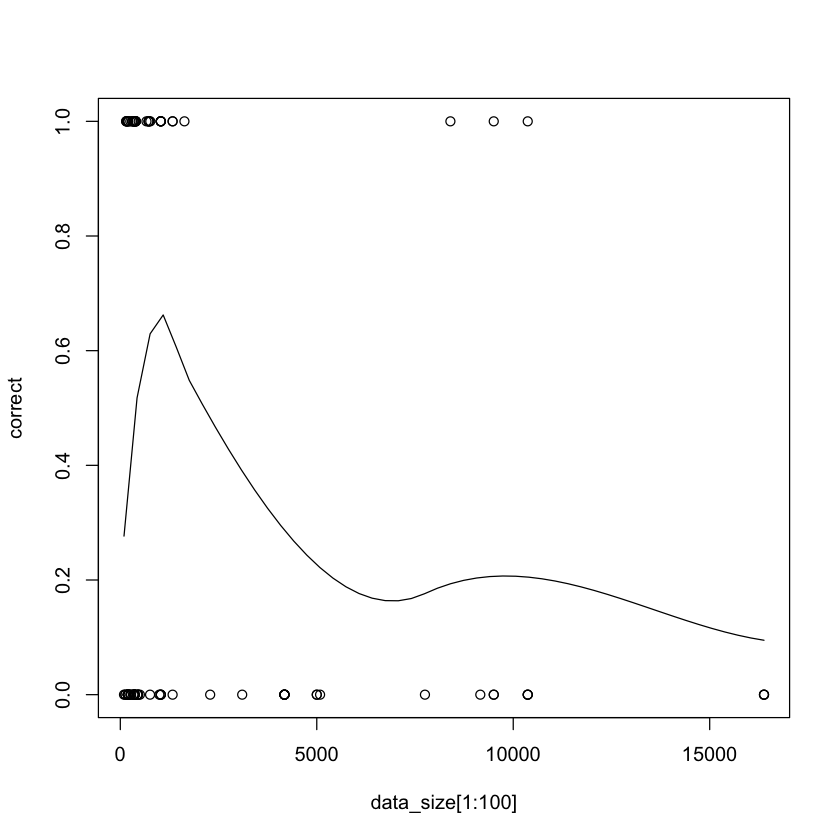

In [464]:
scatter.smooth(x=data_size[1:100], y=correct)

# 8. Analyze Linear Regression Results

In [690]:
forward_models

[[1]]

Call:  glm(formula = V2 ~ V1, data = data)

Coefficients:
(Intercept)           V1  
   9.330263    -0.003876  

Degrees of Freedom: 348 Total (i.e. Null);  347 Residual
Null Deviance:	    802.4 
Residual Deviance: 200.5 	AIC: 803

[[2]]

Call:  glm(formula = V2 ~ V1, data = data)

Coefficients:
(Intercept)           V1  
   633.8777       0.7147  

Degrees of Freedom: 348 Total (i.e. Null);  347 Residual
Null Deviance:	    35430000 
Residual Deviance: 14970000 	AIC: 4719

[[3]]

Call:  glm(formula = V2 ~ V1, data = data)

Coefficients:
(Intercept)           V1  
     9.8733      -0.1837  

Degrees of Freedom: 348 Total (i.e. Null);  347 Residual
Null Deviance:	    802.4 
Residual Deviance: 757 	AIC: 1267

[[4]]

Call:  glm(formula = V2 ~ V1, data = data)

Coefficients:
(Intercept)           V1  
  1517.7877       0.0558  

Degrees of Freedom: 348 Total (i.e. Null);  347 Residual
Null Deviance:	    5694000 
Residual Deviance: 5569000 	AIC: 4374

[[5]]

Call:  glm(formula = V2 ~ 

In [691]:
backward_models

[[1]]

Call:  glm(formula = V1 ~ V2, data = data)

Coefficients:
(Intercept)           V2  
     1888.7       -193.5  

Degrees of Freedom: 348 Total (i.e. Null);  347 Residual
Null Deviance:	    40060000 
Residual Deviance: 10010000 	AIC: 4579

[[2]]

Call:  glm(formula = V1 ~ V2, data = data)

Coefficients:
(Intercept)           V2  
  -371.7358       0.8081  

Degrees of Freedom: 348 Total (i.e. Null);  347 Residual
Null Deviance:	    40060000 
Residual Deviance: 16930000 	AIC: 4762

[[3]]

Call:  glm(formula = V1 ~ V2, data = data)

Coefficients:
(Intercept)           V2  
    12.4449      -0.3079  

Degrees of Freedom: 348 Total (i.e. Null);  347 Residual
Null Deviance:	    1345 
Residual Deviance: 1269 	AIC: 1447

[[4]]

Call:  glm(formula = V1 ~ V2, data = data)

Coefficients:
(Intercept)           V2  
  -270.7154       0.3926  

Degrees of Freedom: 348 Total (i.e. Null);  347 Residual
Null Deviance:	    40060000 
Residual Deviance: 39190000 	AIC: 5055

[[5]]

Call:  glm(formul

# 9. Write Results to a CSV

In [814]:
p_value_ratios = c()
for (i in 1:100) {
    if (results[i, 2] == "0" & results[i, 3] == "0") {
        p_value_ratios = c(p_value_ratios, NA)
    } else if (results[i, 2] == "0") {
        p_value_ratios = c(p_value_ratios, 0)
    } else if (results[i, 3] == "0") {
        p_value_ratios = c(p_value_ratios, NA)
    } else {
        p_value_ratios = c(p_value_ratios, log10(as.numeric(results[i, 2]) / as.numeric(results[i, 3])))
    }
}
print(p_value_ratios)

  [1]    8.36762904    0.57348888   11.66908686    3.68435045    0.00000000
  [6]    0.00000000    0.00000000 -276.50179770    0.00000000    0.00000000
 [11]    0.00000000 -101.78276221   31.50334618   16.35265994    9.70679636
 [16]   32.23720227    0.00000000    4.05590327   15.38014688    0.85006880
 [21]   12.75580363   -8.00785057   -0.24034236   -0.61934871    7.49751591
 [26]    2.66146566    0.72807690   -3.28107125   24.05462060   -0.25239885
 [31]    4.85021342  107.61757184    6.61303909    0.40039444   -9.99778048
 [36]   -1.51097399  -21.98977311   -0.32995802    8.50541138   23.40950976
 [41]   10.26050241            NA            NA -134.84277596            NA
 [46]            NA   -8.39318468   -3.15443534   -7.43984158   -1.41751829
 [51]    4.79557771            NA            NA            NA            NA
 [56]   14.29486541    9.82705016    6.71510784    8.53658309    6.64345974
 [61]    4.68544909    3.03696551    6.12495678    1.56982843    3.24761382
 [66]   -0.8

In [818]:
print(results[43,])
print(results[44,])
print(results[45,])
print(results[46,])

[1] "NA" "0"  "0" 
[1] "Y"                     "1.10217646471203e-318" "7.67409356693388e-184"
[1] "X"                    "6.7638496884355e-303" "0"                   
[1] "NA" "0"  "0" 


In [807]:
for (i in 1:100) {
    if (results[i, 1] == "NA") {
        correct[i] <- NA
    }
}

In [825]:
all_results = data.frame(
    1:100, 
    results[, 1][1:100], 
    correct_answers,
    correct, 
    results[, 2][1:100], 
    results[, 3][1:100],
    p_value_ratios,
    data_size[1:100],
    weights
)
print(all_results)
write.csv(all_results, file = "./pair_test_results")

    X1.100 results...1..1.100. correct_answers correct   results...2..1.100.
1        1                   X               X    TRUE  6.37634844718238e-17
2        2                  NA               X      NA  8.97362197664129e-17
3        3                   X               X    TRUE  9.53978927992768e-08
4        4                   X               X    TRUE    0.0182466355584996
5        5                   Y               X   FALSE                     0
6        6                   Y               X   FALSE                     0
7        7                   Y               X   FALSE                     0
8        8                   Y               X   FALSE 7.80129654783328e-321
9        9                   Y               X   FALSE                     0
10      10                   Y               X   FALSE                     0
11      11                   Y               X   FALSE                     0
12      12                   Y               X   FALSE 1.64175623579961e-289

In [761]:
# forward_intercepts = c()
# forward_intecept_std_errors = c()
# forward_intercept_t = c()
# forward_intercept_v = c()
# forward_v1 = c()
# forward_v1_std_errors = c()
# forward_v1_t = c()
# forward_v1_p = c()
# for (i in 1:108)

summary(forward_models[[3]])


Call:
glm(formula = V2 ~ V1, data = data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-12.6558   -0.5713    0.3873    0.9059    2.3905  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.87332    0.40926  24.125  < 2e-16 ***
V1          -0.18375    0.04028  -4.562 7.05e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 2.181696)

    Null deviance: 802.45  on 348  degrees of freedom
Residual deviance: 757.05  on 347  degrees of freedom
AIC: 1266.7

Number of Fisher Scoring iterations: 2


### 

In [ ]:
glm